# Análise de Clusters
<p>Objetivo dessa análise separar os filmes do dataset em grupos de elementos que possuem um perfil semelhante de alcance e disponibilidade. Esse agrupamento será feito com base nas variáveis 'total_languages', 'total_countries' e 'total_streaming'.</p>

### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer.factor_analyzer import calculate_kmo

In [2]:
df = pd.read_csv("../T3/Dataset.csv")
columns = ['total_languages', 'total_countries', 'total_streaming','titulo'] #variáveis de interesse
df = df[columns]

### Verificar se há multicolinearidade entre as variáveis de interesse
<p>É necessário verificar a multicolinearidade, pois em métricas de distância como a euclidiana, haverá uma distorção dos resultados.</p>

In [3]:
columns = ['total_languages', 'total_countries', 'total_streaming']
msa, kmo = calculate_kmo(df[columns])
print(f"MSA para cada variável: \n{msa}")
print(f"KMO: {kmo}")

MSA para cada variável: 
[0.47450141 0.43979586 0.45283698]
KMO: 0.4602344239943795


<p>Como o MSA de cada varíavel é < 0,50 e o KMO < 0,5, portanto não há multicolinearidade entre essas variáveis. Logo, pode-se aplicar métricas de distâncias como a euclidiana.</p>

### Verificar a presença de outliers

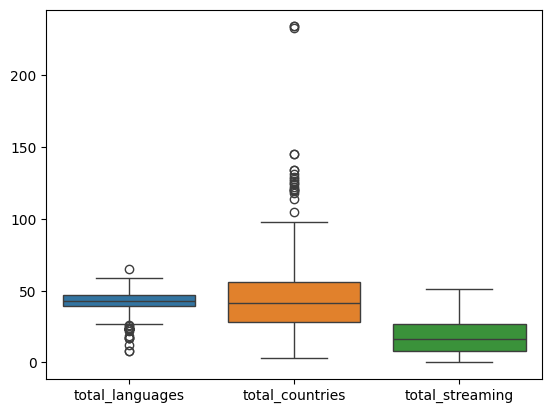

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df[columns])
plt.show()

<p>Analisando o gráfico de Boxplots, observa-se que há outliers presentes nas variáveis 'total_languages' e 'total_countries'</p>

In [5]:
df['total_countries'] = np.log1p(df['total_countries'])
df['total_languages'] = np.log1p(df['total_languages'])

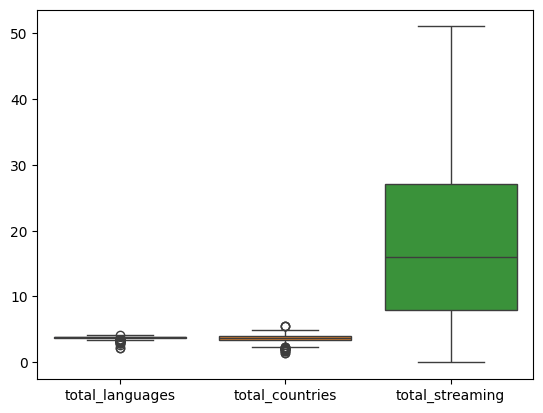

In [6]:
sns.boxplot(data=df[columns])
plt.show()

### Padronização dos dados

In [7]:
df.describe()

,total_languages,total_countries,total_streaming
count,606.000000,606.000000,606.000000
mean,3.752552,3.663488,18.298680
std,0.208571,0.578532,11.324875
min,2.197225,1.386294,0.000000
25%,3.688879,3.367296,8.000000
50%,3.784190,3.737670,16.000000
75%,3.871201,4.043051,27.000000
max,4.189655,5.459586,51.000000


In [8]:
from sklearn.preprocessing import StandardScaler

#Padronização com z-score
scaler = StandardScaler()
df_standard = scaler.fit_transform(df[columns])
df_p = pd.DataFrame(df_standard, columns=columns)

In [9]:
df.head()

,total_languages,total_countries,total_streaming,titulo
0,3.912023,4.127134,0.0,Deadpool & Wolverine
1,3.871201,4.828314,5.0,Divertida Mente 2
2,3.784190,3.951244,3.0,Meu Malvado Favorito 4
3,3.737670,3.891820,3.0,Twisters
4,3.737670,3.828641,8.0,Bad Boys: Até o Fim


### Análise de Clusters através de K-Means

### K-Means

In [10]:
from sklearn.cluster import KMeans

def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

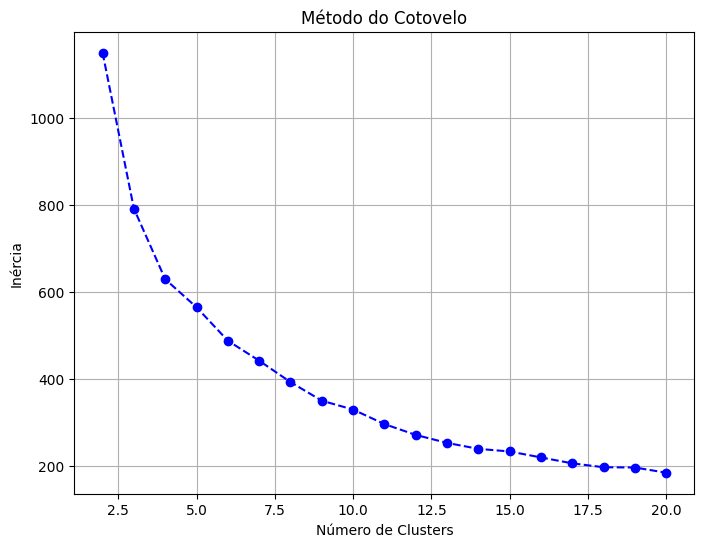

In [11]:
inertia = calculate_wcss(df_p[columns])
# Exibindo o gráfico
plt.figure(figsize=(8, 6))
plt.plot(range(2, 21), inertia, marker='o', color='b', linestyle='--')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import silhouette_score
def score_quality(data):
    k_range = range(2, 21)
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)  # Calcula o índice de silhueta
        silhouette_scores.append(score)
    return silhouette_scores

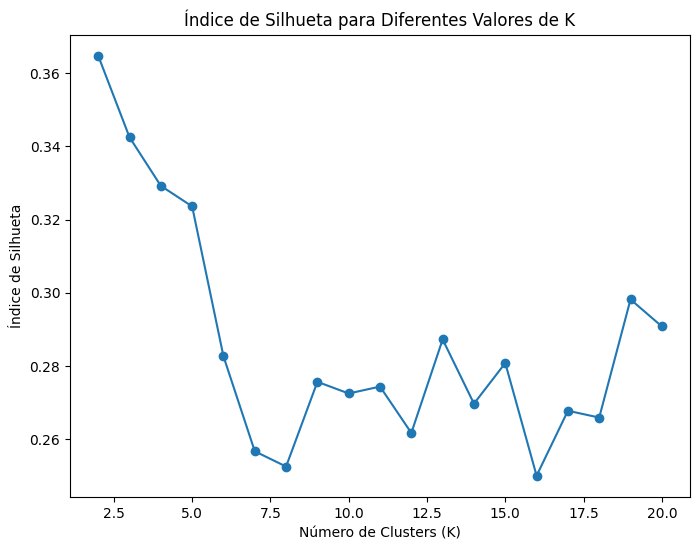

In [13]:
scores = score_quality(df_p[columns])
plt.figure(figsize=(8, 6))
plt.plot(range(2, 21), scores, marker='o')
plt.title('Índice de Silhueta para Diferentes Valores de K')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Índice de Silhueta')
plt.show()

In [14]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] =kmeans.fit_predict(df_p[columns])

In [15]:
from sklearn.decomposition import PCA
# Aplicando PCA para reduzir para 2 componentes principais
pca = PCA(n_components=2)
pca = pca.fit_transform(df_p[columns])

# Criando um DataFrame com os componentes principais
df_pca = pd.DataFrame(pca, columns=['PCA1', 'PCA2'])

# Adicionando a coluna de clusters
df_pca['cluster'] = df['cluster']

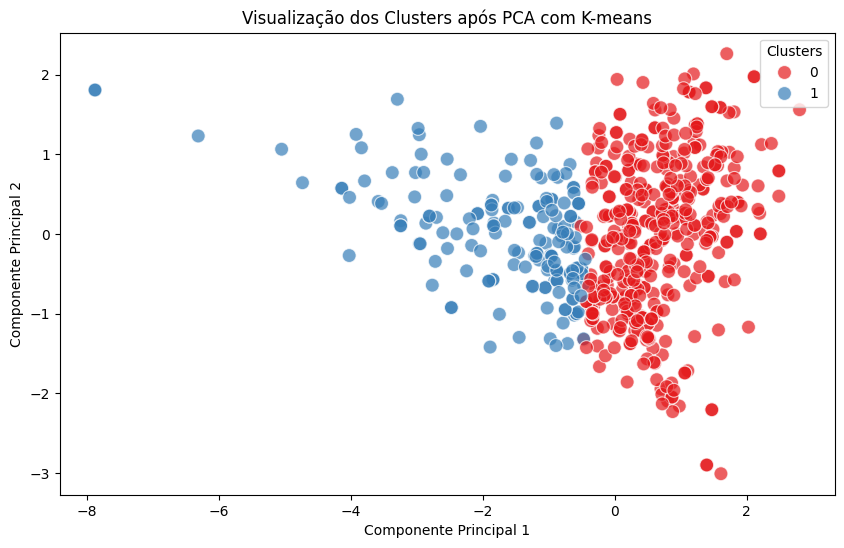

In [16]:
# Plotando os clusters no gráfico PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df_pca, palette='Set1', s=100, alpha=0.7)
plt.title('Visualização dos Clusters após PCA com K-means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Clusters')
plt.show()

### Mantendo o outliers

In [17]:
df_out = pd.read_csv("../T3/Dataset.csv")
columns = ['total_languages', 'total_countries', 'total_streaming', 'titulo'] #variáveis de interesse
df_out = df_out[columns]

In [18]:
columns = ['total_languages', 'total_countries', 'total_streaming']
df_out_standard = scaler.fit_transform(df_out[columns])
out_str = pd.DataFrame(df_out_standard, columns=columns)

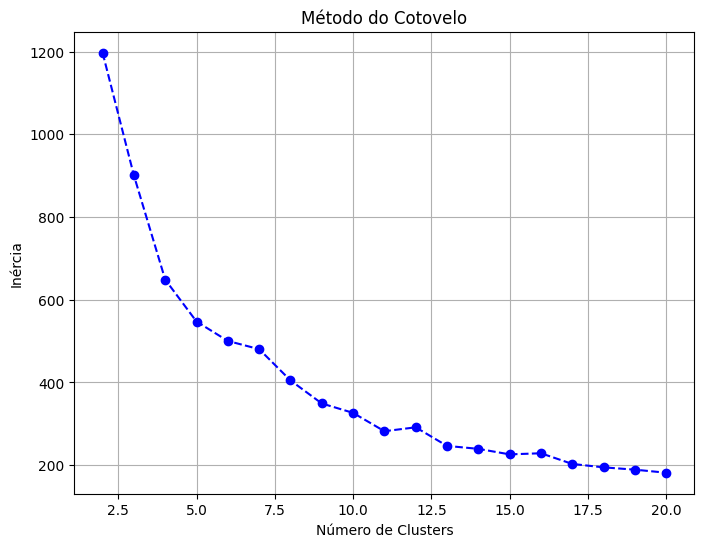

In [19]:
inertia = calculate_wcss(out_str[columns])
# Exibindo o gráfico
plt.figure(figsize=(8, 6))
plt.plot(range(2, 21), inertia, marker='o', color='b', linestyle='--')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()

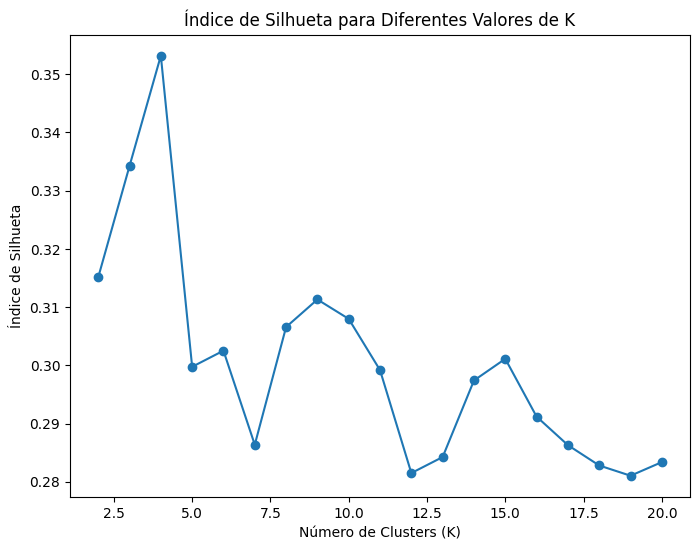

In [20]:
scores = score_quality(out_str[columns])
plt.figure(figsize=(8, 6))
plt.plot(range(2, 21), scores, marker='o')
plt.title('Índice de Silhueta para Diferentes Valores de K')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Índice de Silhueta')
plt.show()

In [21]:
kmeans_out = KMeans(n_clusters=4, random_state=42)
df_out['cluster'] =kmeans_out.fit_predict(out_str[columns])

In [22]:
# Aplicando PCA para reduzir para 2 componentes principais
pca_out = PCA(n_components=2)
pca_out = pca_out.fit_transform(out_str[columns])

# Criando um DataFrame com os componentes principais
df_pca_out = pd.DataFrame(pca_out, columns=['PCA1', 'PCA2'])

# Adicionando a coluna de clusters
df_pca_out['cluster'] = df_out['cluster']

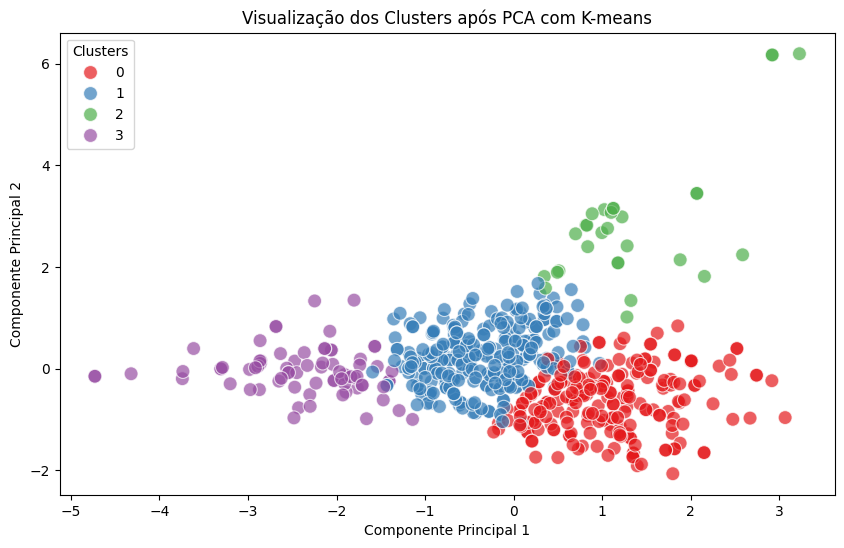

In [23]:
# Plotando os clusters no gráfico PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df_pca_out, palette='Set1', s=100, alpha=0.7)
plt.title('Visualização dos Clusters após PCA com K-means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Clusters')
plt.show()

### Interpretando os resultados

In [26]:
#Com transformação log
cl1_summary = df[['total_countries', 'total_languages', 'total_streaming', 'cluster']].groupby('cluster').mean()
print(cl1_summary)

         total_countries  total_languages  total_streaming
cluster                                                   
0               3.904444         3.834947        22.115741
1               3.065251         3.547984         8.821839


In [27]:
#Sem transformação log
cl2_summary = df_out[['total_countries', 'total_languages', 'total_streaming', 'cluster']].groupby('cluster').mean()
print(cl2_summary)

         total_countries  total_languages  total_streaming
cluster                                                   
0              47.506787        47.108597        30.642534
1              40.807143        42.300000        12.625000
2             127.206897        45.827586         9.000000
3              17.868421        27.986842         6.855263


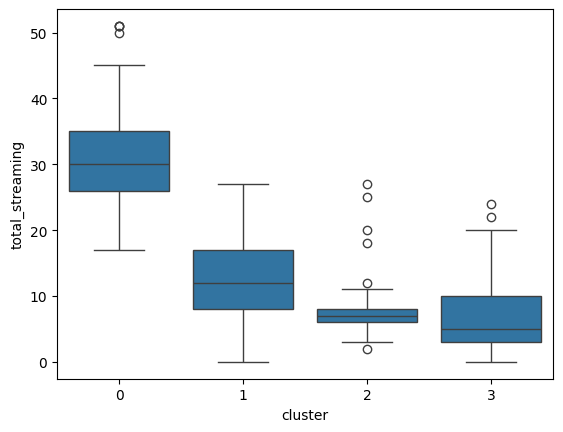

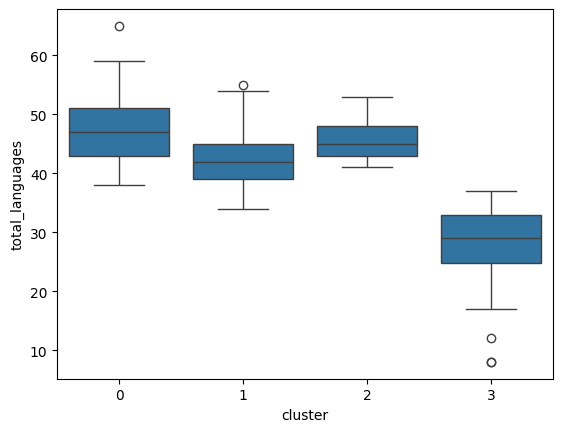

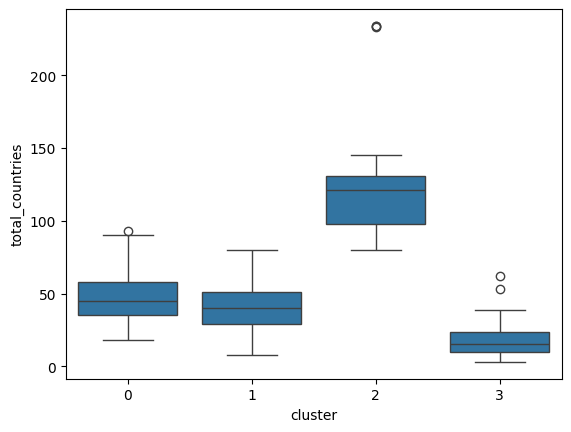

In [28]:
sns.boxplot(x='cluster', y='total_streaming', data=df_out)
plt.show()
sns.boxplot(x='cluster', y='total_languages', data=df_out)
plt.show()
sns.boxplot(x='cluster', y='total_countries', data=df_out)
plt.show()

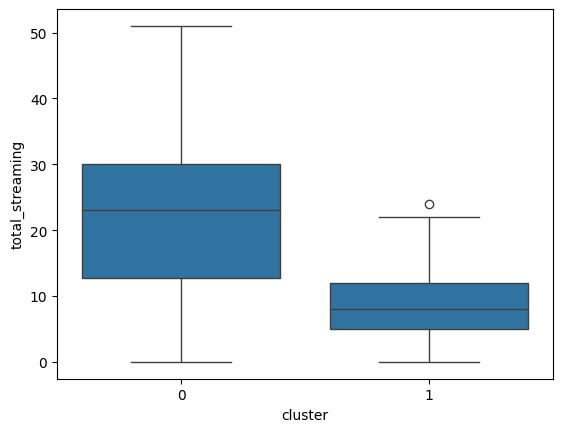

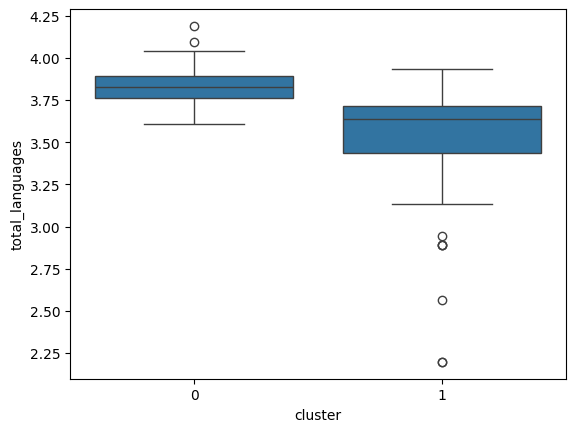

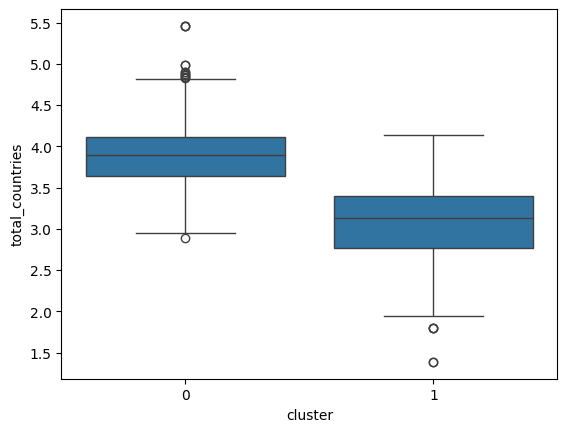

In [29]:
sns.boxplot(x='cluster', y='total_streaming', data=df)
plt.show()
sns.boxplot(x='cluster', y='total_languages', data=df)
plt.show()
sns.boxplot(x='cluster', y='total_countries', data=df)
plt.show()

## Para os cluster sem tratamento
<p>Analisando o cluster '2', percebe-se que os filmes estão disponíveis em muitos países, mas em poucas plataformas: então se trata de filmes recém lançados.</p>
<p>Analisando o cluster '3', percebe-se que os filmes são pouco acessíveis de forma geral. Olhando para o dataset, observou-se que são filmes que obtiveram baixos rendimentos financeiros, tanto em orçamento, quanto em receita.</p>
<p>Analisando o cluster '1', percebe-se que os filmes possuem uma disponibilidade boa em termos de idiomas e países, mas estão presentes em poucas plataformas. Nesse sentido, observando as tuplas, viu-se que se trata de filmes de Marvel e Disney em sua maioria. Portanto, visto que a Disney e a Marvel somente publicam suas obras na Disney+, logo esses filmes irão estar em poucas plataformas.</p>
<p>Analisando o cluster '0', percebe-se que os filmes possuem alta disponibilidade. Nesse sentido, são filmes que fizeram sucesso, que foram lançados a algum tempo e cuja as produtoras não restrigem suas obras exclusivamente a própria plataforma de streaming.</p>

In [37]:
print(df[df['cluster'] == 0])
df[df['cluster'] == 0].to_csv('cluster_0_log_data.csv', index=False)

     total_languages  total_countries  total_streaming  \
0           3.912023         4.127134              0.0   
1           3.871201         4.828314              5.0   
2           3.784190         3.951244              3.0   
3           3.737670         3.891820              3.0   
4           3.737670         3.828641              8.0   
..               ...              ...              ...   
595         3.951244         4.143135             25.0   
599         3.688879         3.931826             22.0   
600         3.737670         4.317488             12.0   
603         3.784190         4.564348             25.0   
604         3.637586         3.850148             24.0   

                                     titulo  cluster  
0                      Deadpool & Wolverine        0  
1                         Divertida Mente 2        0  
2                    Meu Malvado Favorito 4        0  
3                                  Twisters        0  
4                       Bad 

In [39]:
print(df[df['cluster'] == 1])
df[df['cluster'] == 1].to_csv('cluster_1_log_data.csv', index=False)

     total_languages  total_countries  total_streaming  \
5           3.178054         3.401197              2.0   
7           3.713572         3.737670              5.0   
9           3.401197         2.890372              3.0   
10          3.218876         2.484907             16.0   
14          3.828641         3.688879              1.0   
..               ...              ...              ...   
597         3.713572         3.044522              4.0   
598         3.713572         3.713572              8.0   
601         3.610918         2.944439             18.0   
602         3.178054         2.197225              1.0   
605         3.610918         3.258097             16.0   

                                               titulo  cluster  
5                            KILL: O Massacre no Trem        1  
7                                   É Assim Que Acaba        1  
9                                 A Menina e o Dragão        1  
10                                         

In [33]:
df_out[df_out['cluster'] == 0]

,total_languages,total_countries,total_streaming,titulo,cluster
27,51.0,30.0,30.0,O Poderoso Chefão,0
28,45.0,50.0,27.0,Patos!,0
47,53.0,60.0,17.0,Homem-Aranha: Sem Volta Para Casa,0
52,47.0,56.0,32.0,John Wick 4: Baba Yaga,0
53,43.0,22.0,29.0,Os Fantasmas se Divertem,0
...,...,...,...,...,...
580,42.0,32.0,38.0,Hotel Transilvânia 3: Férias Monstruosas,0
582,50.0,65.0,25.0,Tróia,0
584,41.0,52.0,37.0,Drive,0
594,42.0,25.0,28.0,Hancock,0


In [40]:
df_out[df_out['cluster'] == 0].to_csv('cluster_0_data.csv', index=False)

In [41]:
df_out[df_out['cluster'] == 1].to_csv('cluster_1_data.csv', index=False)

In [42]:
df_out[df_out['cluster'] == 2].to_csv('cluster_2_data.csv', index=False)

In [43]:
df_out[df_out['cluster'] == 3].to_csv('cluster_3_data.csv', index=False)

In [34]:
df_out[df_out['cluster'] == 1]

,total_languages,total_countries,total_streaming,titulo,cluster
0,49.0,61.0,0.0,Deadpool & Wolverine,1
2,43.0,51.0,3.0,Meu Malvado Favorito 4,1
3,41.0,48.0,3.0,Twisters,1
4,41.0,45.0,8.0,Bad Boys: Até o Fim,1
6,45.0,52.0,0.0,Alien: Romulus,1
...,...,...,...,...,...
599,39.0,50.0,22.0,Que Horas Eu Te Pego?,1
600,41.0,74.0,12.0,Quarteto Fantástico,1
601,36.0,18.0,18.0,A Mosca,1
604,37.0,46.0,24.0,Erin Brockovich: Uma Mulher de Talento,1


In [35]:
df_out[df_out['cluster'] == 2]

,total_languages,total_countries,total_streaming,titulo,cluster
1,47.0,124.0,5.0,Divertida Mente 2,2
12,42.0,122.0,7.0,Planeta dos Macacos: O Reinado,2
24,53.0,80.0,12.0,Vingadores: Guerra Infinita,2
43,44.0,119.0,8.0,As Marvels,2
46,53.0,129.0,20.0,Homem-Aranha: Através do Aranhaverso,2
50,48.0,121.0,18.0,Duna: Parte Dois,2
59,43.0,131.0,6.0,Wish: O Poder dos Desejos,2
61,51.0,145.0,7.0,Avatar: O Caminho da Água,2
62,45.0,234.0,3.0,Godzilla Minus One,2
73,45.0,234.0,3.0,Godzilla Minus One,2


In [36]:
df_out[df_out['cluster'] == 3]

,total_languages,total_countries,total_streaming,titulo,cluster
5,23.0,29.0,2.0,KILL: O Massacre no Trem,3
9,29.0,17.0,3.0,A Menina e o Dragão,3
10,24.0,11.0,16.0,Farang,3
15,29.0,16.0,0.0,Thelma,3
31,31.0,27.0,4.0,O Exorcismo,3
...,...,...,...,...,...
569,27.0,11.0,6.0,O Estranho,3
570,23.0,7.0,8.0,A Casa do Espanto,3
578,31.0,22.0,22.0,Byzantium: Uma Vida Eterna,3
596,17.0,21.0,1.0,Crepúsculo dos Guerreiros: Walled In,3


In [ ]:
df[df['cluster'] == 1].max()

total_languages     3.931826
total_countries     4.143135
total_streaming    24.000000
cluster             1.000000
dtype: float64

In [ ]:
df[df['cluster'] == 0].max()

total_languages     4.189655
total_countries     5.459586
total_streaming    51.000000
cluster             0.000000
dtype: float64

<p>Analisando os clusters com transformação logaritmica, percebe-se que houve um agrupamento somente em termos de disponibilidade, ignorando outros aspectos que a outra análise considerou</p>